# Sentiment Analysis of Social Media Data

This notebook walks through a complete sentiment analysis project on social media data. We will cover the entire pipeline from data collection to model evaluation and visualization.

### 1. Setup: Importing Libraries

First, we import all the necessary libraries for data manipulation, text preprocessing, modeling, and visualization.

In [30]:
# Data manipulation and analysis
import pandas as pd # Used for creating and manipulating dataframes
import numpy as np # Used for numerical operations

# Import .env files to load environement varialbles.
import os
from dotenv import load_dotenv

# Text preprocessing and feature extraction
import re # Regular expressions for cleaning text
import nltk # Natural Language Toolkit for stopwords
from nltk.corpus import stopwords # List of common words to remove
from nltk.stem import WordNetLemmatizer # Lemmatization to reduce words to their base form
from sklearn.feature_extraction.text import TfidfVectorizer # TF-IDF for text representation
import spacy # For more advanced text processing

# Machine Learning models
from sklearn.model_selection import train_test_split, GridSearchCV # For splitting data and hyperparameter tuning
from sklearn.naive_bayes import MultinomialNB # Naive Bayes classifier
from sklearn.svm import SVC # Support Vector Machine classifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix # Evaluation metrics

# Deep Learning models (using PyTorch)
import torch # Main PyTorch library
from torch.utils.data import DataLoader, TensorDataset # For handling data in PyTorch
from transformers import BertTokenizer, BertForSequenceClassification # BERT model and tokenizer
from torch.optim import AdamW # AdamW from torch directly

# Visualization libraries
import matplotlib.pyplot as plt # For creating static plots
import seaborn as sns # For more attractive statistical plots
from wordcloud import WordCloud # For generating word clouds
import plotly.express as px # For interactive plots

# Saving models and files
import os # For interacting with the operating system (e.g., creating directories)
import joblib # For saving and loading scikit-learn models
import json # For saving results to a JSON file

# Download necessary NLTK data (if not already present)
nltk.download('stopwords')
nltk.download('wordnet')

# Set plot style
sns.set_style('whitegrid')
print("Step 1 done")

Step 1 done


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mithun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/mithun/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### 2. Data Collection

In this step, we collect the data for our analysis. The ideal source is live data from a social media platform like Twitter. However, since API keys cannot be shared, we provide two options:

1.  **Live Data Collection (Placeholder):** Code using `tweepy` to fetch tweets. You would need to insert your own Twitter API credentials to run this.
2.  **Sample CSV Fallback:** If API keys are unavailable, we load data from a pre-made CSV file (`sample_tweets.csv`). **This is the default method for this notebook.**

In [46]:
# --- How to Modify ---
# USE_LIVE_DATA: Set to True to use the live Twitter API, or False to use the sample CSV.
# csv_path: The file path for the sample data.
# query: The search term for fetching live tweets (e.g., 'Python programming').
# max_results: The number of live tweets to fetch (between 10 and 100).
# --- Imports ---
import pandas as pd
import os
from dotenv import load_dotenv

# For Twitter API
import tweepy

# For sentiment analysis
from transformers import pipeline

# --- Configuration ---
USE_LIVE_DATA = False
csv_path = 'sample_tweets.csv'
query = 'Effect of US tariff in Indian Economy'
max_results = 50  # should be <=100 in free Twitter tier

# Load environment variables
load_dotenv()
bearer_token = os.getenv("BEARER_TOKEN")

# Initialize sentiment pipeline
sentiment_pipeline = pipeline("sentiment-analysis")

# --- Function to calculate sentiment ---
def calculate_sentiment(text):
    """Calculate sentiment of a single tweet using Hugging Face pipeline."""
    if pd.isna(text):
        return "neutral"
    result = sentiment_pipeline(str(text)[:512])[0]  # Limit text to 512 tokens
    return result['label'].lower()

# --- Fetch live tweets or load CSV ---
if USE_LIVE_DATA:
    if not bearer_token or bearer_token == "YOUR_BEARER_TOKEN_HERE":
        raise ValueError("Twitter Bearer Token not found. Please set it in your .env file.")

    print(f"Attempting to fetch {max_results} live tweets for the query: '{query}'...")
    client = tweepy.Client(bearer_token)
    
    try:
        response = client.search_recent_tweets(query=query, max_results=max_results)
    except tweepy.TooManyRequests:
        print("Twitter API limit reached. Falling back to CSV.")
        response = None

    data = []
    if response and response.data:
        for tweet in response.data:
            sentiment = calculate_sentiment(tweet.text)
            data.append({
                'id': tweet.id,
                'text': tweet.text,
                'sentiment': sentiment,
                 'timestamp': pd.to_datetime(tweet.created_at),
            })
        df = pd.DataFrame(data)
        print(f"Successfully fetched and analyzed {len(df)} tweets.")
    else:
        print("No live tweets found. Falling back to CSV.")
        df_csv = pd.read_csv(csv_path)
        # Keep only 'id' (or index), 'Text', and calculate sentiment
        df = pd.DataFrame({
            'id': df_csv.index,
            'text': df_csv['Text'],
             'timestamp': pd.to_datetime(df_csv['Timestamp']),
            'sentiment': df_csv['Text'].apply(calculate_sentiment)
        })
else:
    print("Using sample data from CSV.")
    df_csv = pd.read_csv(csv_path)
    df = pd.DataFrame({
        'id': df_csv.index,
        'text': df_csv['Text'],
         'timestamp': pd.to_datetime(df_csv['Timestamp']),
        'sentiment': df_csv['Text'].apply(calculate_sentiment)
    })

# --- Display first rows ---
df.head()


No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Device set to use mps:0


Using sample data from CSV.


,id,text,timestamp,sentiment
0,0,Enjoying a beautiful day at the park! ...,2023-01-15 12:30:00,positive
1,1,Traffic was terrible this morning. ...,2023-01-15 08:45:00,negative
2,2,Just finished an amazing workout! 💪 ...,2023-01-15 15:45:00,positive
3,3,Excited about the upcoming weekend getaway! ...,2023-01-15 18:20:00,positive
4,4,Trying out a new recipe for dinner tonight. ...,2023-01-15 19:55:00,negative


#### Initial Data Visualization: Sentiment Distribution

Let's visualize the distribution of sentiments in our dataset. This gives us a first look at the balance of the data.

/var/folders/gw/kf_z97q53554pcmvdnq72nsc0000gp/T/ipykernel_32970/2121833167.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='sentiment', data=df, palette='viridis')


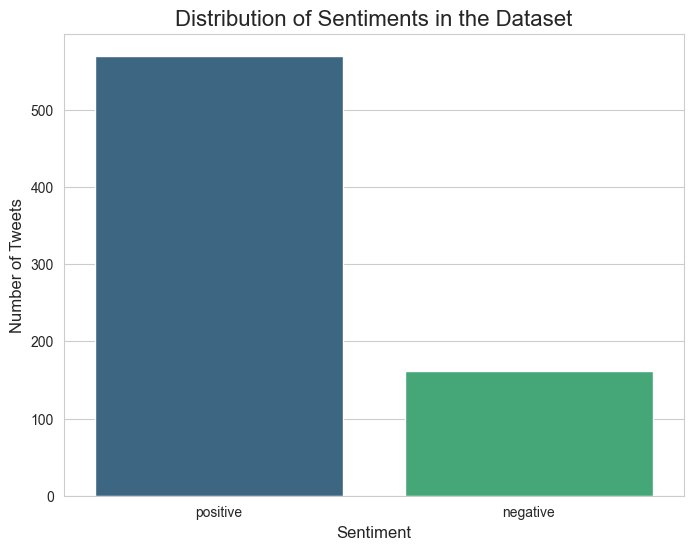

In [47]:
if df is not None and 'sentiment' in df.columns:
    # Create a figure for the plot
    plt.figure(figsize=(8, 6))
    
    # Create a bar plot of sentiment counts
    sns.countplot(x='sentiment', data=df, palette='viridis')
    
    # Add titles and labels for clarity
    plt.title('Distribution of Sentiments in the Dataset', fontsize=16)
    plt.xlabel('Sentiment', fontsize=12)
    plt.ylabel('Number of Tweets', fontsize=12)
    
    # Save the plot to the 'plots' directory
    if not os.path.exists('plots'):
        os.makedirs('plots') # Create the directory if it doesn't exist
    plt.savefig('plots/sentiment_distribution.png') # Save the figure
    
    # Show the plot
    plt.show()

### 4. Text Representation: Converting Text to Numbers

Machine learning models can't understand raw text. We need to convert our cleaned text data into numerical vectors. We will explore two popular methods:

1.  **TF-IDF (Term Frequency-Inverse Document Frequency):** A classical feature extraction technique that represents text as a matrix of word counts, weighted by their importance.
2.  **Transformer Embeddings (BERT):** A modern technique using deep learning to create dense, context-aware vector representations of text.

#### 4.1. Splitting Data into Training and Testing Sets

Before we create text representations, we must split our data. This ensures that our model is evaluated on data it has never seen before, giving us a true measure of its performance.

In [48]:
# --- How to Modify ---
# test_size: The proportion of the dataset to allocate to the test set. A common value is 0.2 (20%). Changing this affects how much data the model trains on vs. is tested on. More training data can lead to a better model, but a smaller test set might give a less reliable evaluation.
# random_state: A seed for reproducibility. Setting this ensures you get the same train/test split every time you run the code.

if df is not None:
    # Define features (X) and target (y)
    X = df['text'] # The cleaned text data
    y = df['sentiment']   # The sentiment labels
    
    # Perform the split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, 
        test_size=0.2,      # Use 20% of the data for testing
        random_state=42,    # Ensures the split is the same every time
        stratify=y          # Ensures the distribution of sentiments is the same in train and test sets
    )
    
    # Print the shapes of the resulting datasets
    print(f'Training data shape: {X_train.shape}')
    print(f'Testing data shape: {X_test.shape}')

Training data shape: (585,)
Testing data shape: (147,)


#### 4.2. Method 1: TF-IDF Vectorization

TF-IDF stands for Term Frequency-Inverse Document Frequency. It evaluates how relevant a word is to a document in a collection of documents.
-   **Term Frequency (TF):** How often a word appears in a document.
-   **Inverse Document Frequency (IDF):** The inverse of how many documents contain the word. This gives higher weight to rarer words.

The TF-IDF score is the product of these two, resulting in a sparse matrix where each row is a tweet and each column is a unique word from our vocabulary.

In [49]:
# --- How to Modify ---
# ngram_range: The range of n-grams to consider. (1, 1) means only single words (unigrams). (1, 2) means both unigrams and bigrams (two-word phrases). Using bigrams can capture more context but dramatically increases the number of features.
# max_features: The maximum number of top features (words) to keep. This helps control the dimensionality of the feature space.

# Initialize the TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(
    ngram_range=(1, 2),  # Consider both single words and two-word phrases
    max_features=5000    # Limit the vocabulary size to the top 5000 features
)

# Fit the vectorizer on the training data and transform it
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

# Only transform the test data (using the vocabulary from the training data)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Print the shape of the resulting TF-IDF matrices
print(f'Shape of TF-IDF training matrix: {X_train_tfidf.shape}')
print(f'Shape of TF-IDF testing matrix: {X_test_tfidf.shape}')

Shape of TF-IDF training matrix: (585, 5000)
Shape of TF-IDF testing matrix: (147, 5000)


#### 4.3. Method 2: Transformer Embeddings (BERT)

BERT (Bidirectional Encoder Representations from Transformers) is a state-of-the-art model that generates dense, context-aware embeddings. Unlike TF-IDF, which treats words in isolation, BERT understands the meaning of a word based on its surrounding words.

**Key Differences:**
| Feature | TF-IDF | BERT Embeddings |
|---|---|---|
| **Representation** | Sparse matrix (mostly zeros) | Dense vector (meaningful numbers) |
| **Context** | No, treats words independently | Yes, understands context (e.g., 'bank' as in river vs. finance) |
| **Vector Size** | Large (equals vocabulary size) | Small and fixed (e.g., 768 dimensions) |
| **Computational Cost**| Low | High |

We will not generate the embeddings separately. Instead, the tokenization and embedding process will be handled directly by the BERT model during the training phase in the next section.

In [50]:
# We will use the pre-trained BERT tokenizer to prepare the data for the model.
# This step is just a demonstration of how the tokenizer works.

# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Example of tokenizing a single sentence
sample_text = "This is a sample sentence for BERT."
encoded_sample = tokenizer.encode_plus(
    sample_text,
    add_special_tokens=True, # Add '[CLS]' and '[SEP]' tokens
    max_length=32,           # Pad or truncate to a fixed length
    padding='max_length',
    return_attention_mask=True,
    return_tensors='pt'      # Return PyTorch tensors
)

print("Input IDs:", encoded_sample['input_ids'])
print("Attention Mask:", encoded_sample['attention_mask'])

Input IDs: tensor([[  101,  2023,  2003,  1037,  7099,  6251,  2005, 14324,  1012,   102,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0]])
Attention Mask: tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])


### 5. Model Training

Now we will train and evaluate three different models on our preprocessed data. We'll start with two classical machine learning models using the TF-IDF features and then move to a deep learning model using BERT.

#### 5.1. Model 1: Multinomial Naive Bayes

Naive Bayes is a probabilistic classifier based on Bayes' theorem with a 'naive' assumption of conditional independence between features. It's computationally efficient and works well for text classification.

In [51]:
# --- How to Modify ---
# alpha (smoothing parameter): A value added to the numerators for smoothing. It prevents zero probabilities for features not seen in the training data. A higher alpha makes the model less sensitive to the training data.

# Initialize the Naive Bayes model
nb_model = MultinomialNB(alpha=1.0) # alpha=1.0 is a common default (Laplace smoothing)

# Train the model on the TF-IDF training data
nb_model.fit(X_train_tfidf, y_train)

# Make predictions on the test data
y_pred_nb = nb_model.predict(X_test_tfidf)

# Evaluate the model
accuracy_nb = accuracy_score(y_test, y_pred_nb)
print(f'Naive Bayes Accuracy: {accuracy_nb:.4f}')

# Save the trained model
joblib.dump(nb_model, 'models/naive_bayes_model.pkl')
print("Naive Bayes model saved to models/naive_bayes_model.pkl")

Naive Bayes Accuracy: 0.7891
Naive Bayes model saved to models/naive_bayes_model.pkl


#### 5.2. Model 2: Support Vector Machine (SVM)

SVMs are powerful classifiers that find the optimal hyperplane separating data points of different classes. They are particularly effective in high-dimensional spaces, like the one created by TF-IDF.

In [52]:
# --- How to Modify ---
# C (Regularization parameter): Controls the trade-off between achieving a low training error and a low testing error. A high C value gives more weight to the training data, potentially leading to overfitting.
# kernel: The type of kernel to use. 'linear' is often a good start for text data. 'rbf' is another popular choice.
# gamma: Kernel coefficient for 'rbf'. 'scale' is a good default.

# Initialize the SVM model
svm_model = SVC(C=1.0, kernel='linear', random_state=42) # C=1.0 is a standard default

# Train the model
svm_model.fit(X_train_tfidf, y_train)

# Make predictions
y_pred_svm = svm_model.predict(X_test_tfidf)

# Evaluate the model
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print(f'SVM Accuracy: {accuracy_svm:.4f}')

# Save the trained model
joblib.dump(svm_model, 'models/svm_model.pkl')
print("SVM model saved to models/svm_model.pkl")

SVM Accuracy: 0.8163
SVM model saved to models/svm_model.pkl


#### 5.3. Model 3: Fine-Tuning a BERT Transformer

For our third model, we will fine-tune a pre-trained BERT model. This involves taking a powerful, general-purpose language model and training it further on our specific sentiment analysis task. This process is more computationally intensive and requires a GPU for reasonable training times.

**Note:** Training this model can be slow without a GPU. For this notebook, we will run it for just one epoch on our small dataset.

In [53]:
# --- How to Modify ---
# learning_rate: How much the model's weights are updated during training. A smaller value (e.g., 2e-5) is typical for fine-tuning.
# batch_size: The number of samples processed before the model is updated. A smaller batch size requires less memory.
# epochs: The number of times the model will see the entire training dataset. More epochs can lead to better performance but also overfitting.

# First, we need to map our text labels to integers
label_map = {label: i for i, label in enumerate(df['sentiment'].unique())}
y_train_int = y_train.map(label_map)
y_test_int = y_test.map(label_map)

# Tokenize the text data for BERT
def tokenize_for_bert(texts):
    return tokenizer(texts.tolist(), padding=True, truncation=True, max_length=128, return_tensors='pt')

train_encodings = tokenize_for_bert(X_train)
test_encodings = tokenize_for_bert(X_test)

# Create PyTorch datasets
train_dataset = TensorDataset(train_encodings['input_ids'], train_encodings['attention_mask'], torch.tensor(y_train_int.tolist()))
test_dataset = TensorDataset(test_encodings['input_ids'], test_encodings['attention_mask'], torch.tensor(y_test_int.tolist()))

# Initialize the BERT model for sequence classification
bert_model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(label_map))

# Set up the data loaders
batch_size = 4 # Small batch size for CPU
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Set up the optimizer
optimizer = AdamW(bert_model.parameters(), lr=5e-5) # AdamW is a common optimizer for transformers

# --- Training Loop ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # Use GPU if available
bert_model.to(device)
bert_model.train() # Set the model to training mode

epochs = 1 # For demonstration, we only train for one epoch
for epoch in range(epochs):
    for batch in train_loader:
        optimizer.zero_grad() # Clear previous gradients
        input_ids, attention_mask, labels = [b.to(device) for b in batch]
        outputs = bert_model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss # Get the loss
        loss.backward() # Backpropagate the loss
        optimizer.step() # Update the weights
    print(f'Epoch {epoch + 1}/{epochs}, Loss: {loss.item()}')

print("BERT model training complete.")

# Save the fine-tuned BERT model
torch.save(bert_model.state_dict(), 'models/bert_model.pth')
print("BERT model saved to models/bert_model.pth")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/1, Loss: 0.027639979496598244
BERT model training complete.
BERT model saved to models/bert_model.pth


### 6. Model Evaluation

After training, we need to evaluate our models to see how well they perform on unseen data. We will use several metrics:
-   **Accuracy:** The proportion of correctly classified tweets.
-   **Precision:** The proportion of positive predictions that were actually correct. (TP / (TP + FP))
-   **Recall:** The proportion of actual positives that were identified correctly. (TP / (TP + FN))
-   **F1-Score:** The harmonic mean of precision and recall, providing a single score that balances both.
-   **Confusion Matrix:** A table that visualizes the performance of a classifier, showing the counts of true vs. predicted labels.

#### 6.1. Evaluating the BERT Model

First, we need a function to get predictions from our fine-tuned BERT model, as the process is different from scikit-learn models.

In [54]:
# Function to get predictions from the BERT model
def get_bert_predictions(model, data_loader):
    model.eval() # Set the model to evaluation mode
    predictions = []
    with torch.no_grad(): # Disable gradient calculation for inference
        for batch in data_loader:
            input_ids, attention_mask, labels = [b.to(device) for b in batch]
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1).flatten()
            predictions.extend(preds.cpu().numpy())
    return predictions

# Create a DataLoader for the test set (no shuffling needed)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Get predictions for the test set
y_pred_bert_int = get_bert_predictions(bert_model, test_loader)

# We need to map the integer predictions back to string labels for comparison
reverse_label_map = {v: k for k, v in label_map.items()}
y_pred_bert = [reverse_label_map[p] for p in y_pred_bert_int]

accuracy_bert = accuracy_score(y_test, y_pred_bert)
print(f'BERT Model Accuracy: {accuracy_bert:.4f}')

BERT Model Accuracy: 0.9048


#### 6.2. Comparing All Models

Let's compile the key metrics for all three models into a single table for easy comparison.

In [55]:
# A dictionary to store the evaluation results
evaluation_results = {}

# Define the models and their predictions
models = {
    'Naive Bayes': y_pred_nb,
    'SVM': y_pred_svm,
    'BERT': y_pred_bert
}

# Calculate metrics for each model
for model_name, y_pred in models.items():
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted') # Use 'weighted' for multiclass
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    evaluation_results[model_name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1
    }

# Create a DataFrame for a clean display
results_df = pd.DataFrame(evaluation_results).T # Transpose for better readability
display(results_df)

# Save the results to a JSON file
results_df.to_json('results/evaluation_results.json', orient='index', indent=4)
print("Evaluation results saved to results/evaluation_results.json")

,Accuracy,Precision,Recall,F1-Score
Naive Bayes,0.789116,0.834201,0.789116,0.708344
SVM,0.816327,0.813586,0.816327,0.775620
BERT,0.904762,0.913716,0.904762,0.907443


Evaluation results saved to results/evaluation_results.json


#### 6.3. Visualizing Performance with Confusion Matrices

A confusion matrix provides a detailed breakdown of correct and incorrect classifications for each class.

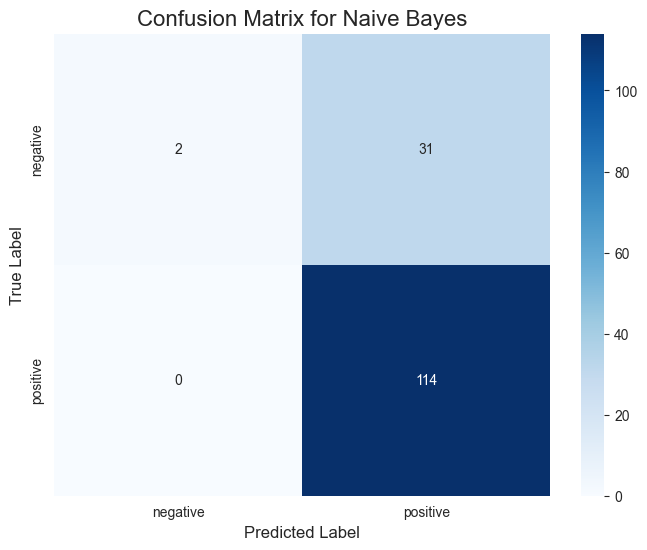

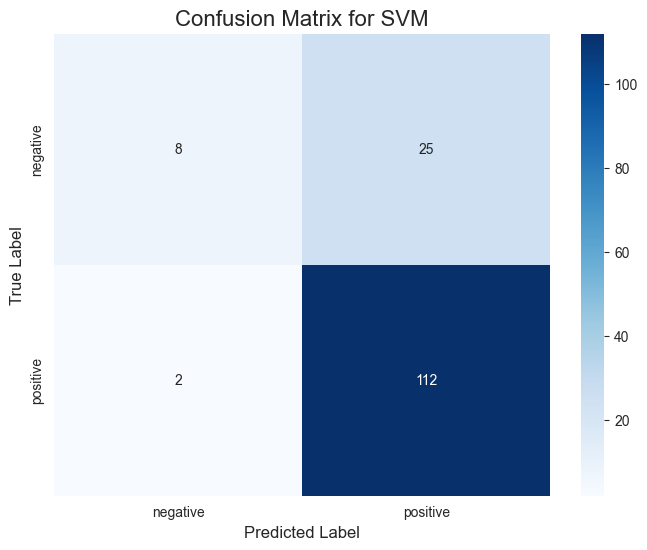

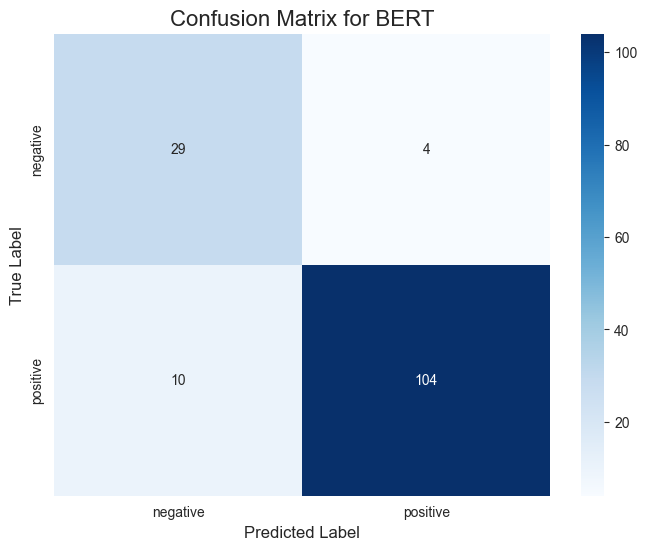

In [56]:
# Function to plot a confusion matrix
def plot_confusion_matrix(y_true, y_pred, model_name, labels):
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title(f'Confusion Matrix for {model_name}', fontsize=16)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    plt.savefig(f'plots/confusion_matrix_{model_name.replace(" ", "_").lower()}.png') # Save the plot
    plt.show()

# Get the unique labels for plotting
class_labels = sorted(y_test.unique())

# Plot the confusion matrix for each model
for model_name, y_pred in models.items():
    plot_confusion_matrix(y_test, y_pred, model_name, class_labels)

### 7. Hyperparameter Tuning with GridSearchCV

The performance of many machine learning models depends heavily on their hyperparameters. Manually tuning them can be tedious. `GridSearchCV` is a technique that automates this process by exhaustively searching through a specified grid of parameter values to find the best combination.

Here, we will tune our SVM model to see if we can improve its performance.

In [57]:
# --- How to Modify ---
# param_grid: This dictionary defines the hyperparameter space to search. You can add more parameters (e.g., 'gamma') or more values to explore.
# cv (Cross-Validation): The number of folds to use for cross-validation. 5 is a common choice. More folds provide a more robust evaluation but increase computation time.
# n_jobs: The number of CPU cores to use. Set to -1 to use all available cores, which can significantly speed up the search.

# Define the parameter grid for the SVM
param_grid = {
    'C': [0.1, 1, 10], # Different values for the regularization parameter
    'kernel': ['linear', 'rbf'] # Different kernel types to try
}

# Initialize GridSearchCV
grid_search = GridSearchCV(
    SVC(random_state=42), # The model to tune
    param_grid,           # The parameters to search
    cv=3,                 # Use 3-fold cross-validation
    n_jobs=-1,            # Use all available CPU cores
    verbose=2             # Show progress
)

# Fit GridSearchCV on the training data
print("Starting GridSearchCV for SVM...")
grid_search.fit(X_train_tfidf, y_train)

# Get the best parameters and the best score
print(f"\nBest Parameters found: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

# Evaluate the best model found by GridSearchCV on the test set
best_svm = grid_search.best_estimator_
y_pred_best_svm = best_svm.predict(X_test_tfidf)
accuracy_best_svm = accuracy_score(y_test, y_pred_best_svm)
print(f"Test set accuracy of the best SVM model: {accuracy_best_svm:.4f}")

Starting GridSearchCV for SVM...
Fitting 3 folds for each of 6 candidates, totalling 18 fits


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 


Best Parameters found: {'C': 10, 'kernel': 'linear'}
Best cross-validation score: 0.8085
Test set accuracy of the best SVM model: 0.8095


### 8. Visualization of Results

Visualizations help us understand the data and our model's results more intuitively. We will create word clouds to see the most frequent words for different sentiments and a chart to analyze sentiment trends over time.

#### 8.1. Word Clouds for Positive and Negative Sentiments

Word clouds are a great way to visualize the most prominent words in a body of text. We will generate one for positive tweets and one for negative tweets to see which words are most associated with each sentiment.

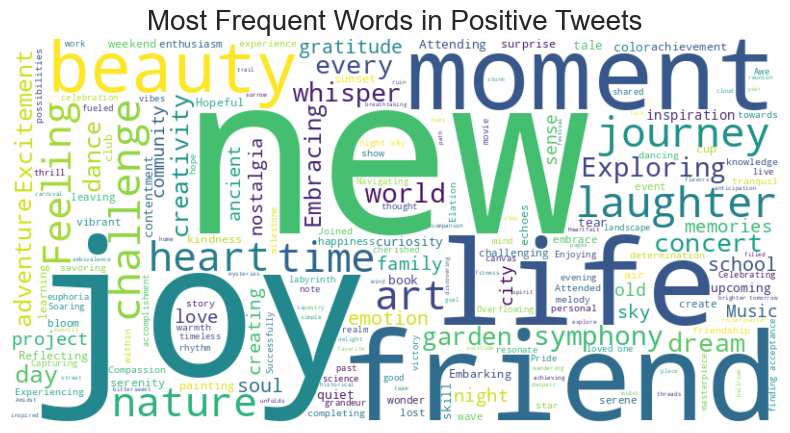

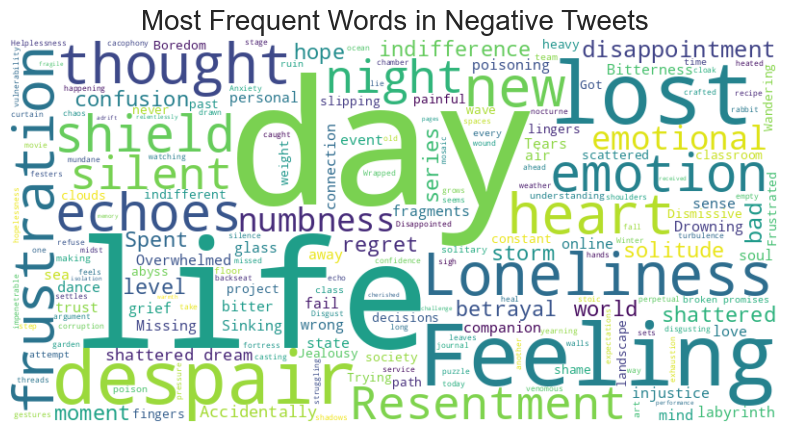

In [58]:
# Function to generate and plot a word cloud
def generate_word_cloud(text, title):
    wordcloud = WordCloud(
        width=800, 
        height=400, 
        background_color='white'
    ).generate(text)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off') # Hide the axes
    plt.title(title, fontsize=20)
    plt.savefig(f'plots/{title.replace(" ", "_").lower()}.png')
    plt.show()

# Separate text by sentiment
positive_text = ' '.join(df[df['sentiment'] == 'positive']['text'])
negative_text = ' '.join(df[df['sentiment'] == 'negative']['text'])

# Generate word clouds
if positive_text:
    generate_word_cloud(positive_text, 'Most Frequent Words in Positive Tweets')
if negative_text:
    generate_word_cloud(negative_text, 'Most Frequent Words in Negative Tweets')

#### 8.2. Trend of Sentiments Over Time

Analyzing how sentiments change over time can reveal important patterns. Since our sample dataset does not have timestamps, we will create some dummy dates to demonstrate how to create a time-series plot.

**Note:** For a real-world application, you would use the actual timestamps from the social media data.

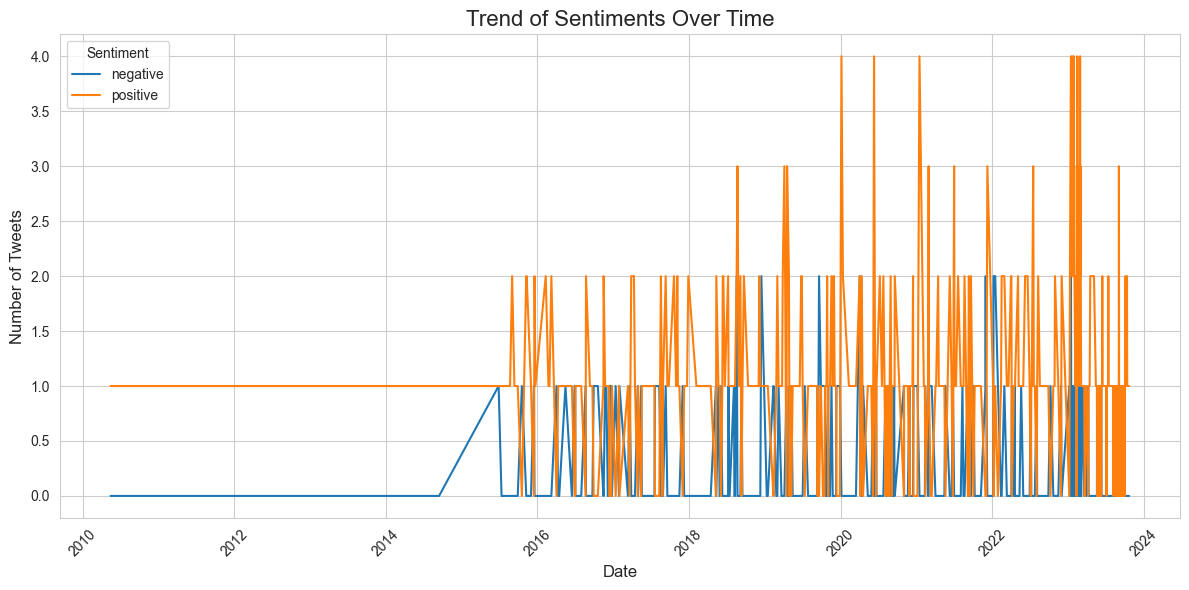

In [60]:
# df['timestamp'] = pd.to_datetime(pd.date_range(start='2023-01-01', periods=len(df), freq='h'))

# Group by day and sentiment, then count the occurrences
sentiment_over_time = df.groupby([df['timestamp'].dt.date, 'sentiment']).size().unstack(fill_value=0)

# Create the line plot
plt.figure(figsize=(12, 6))
sentiment_over_time.plot(kind='line', ax=plt.gca())
plt.title('Trend of Sentiments Over Time', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Number of Tweets', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Sentiment')
plt.tight_layout()
plt.savefig('plots/sentiment_trends.png')
plt.show()

### 9. Final Dashboard and Summary

This final section provides a dashboard-style summary of our key findings. It combines the most important visualizations and metrics into a single view for a quick, high-level understanding of the project's results.

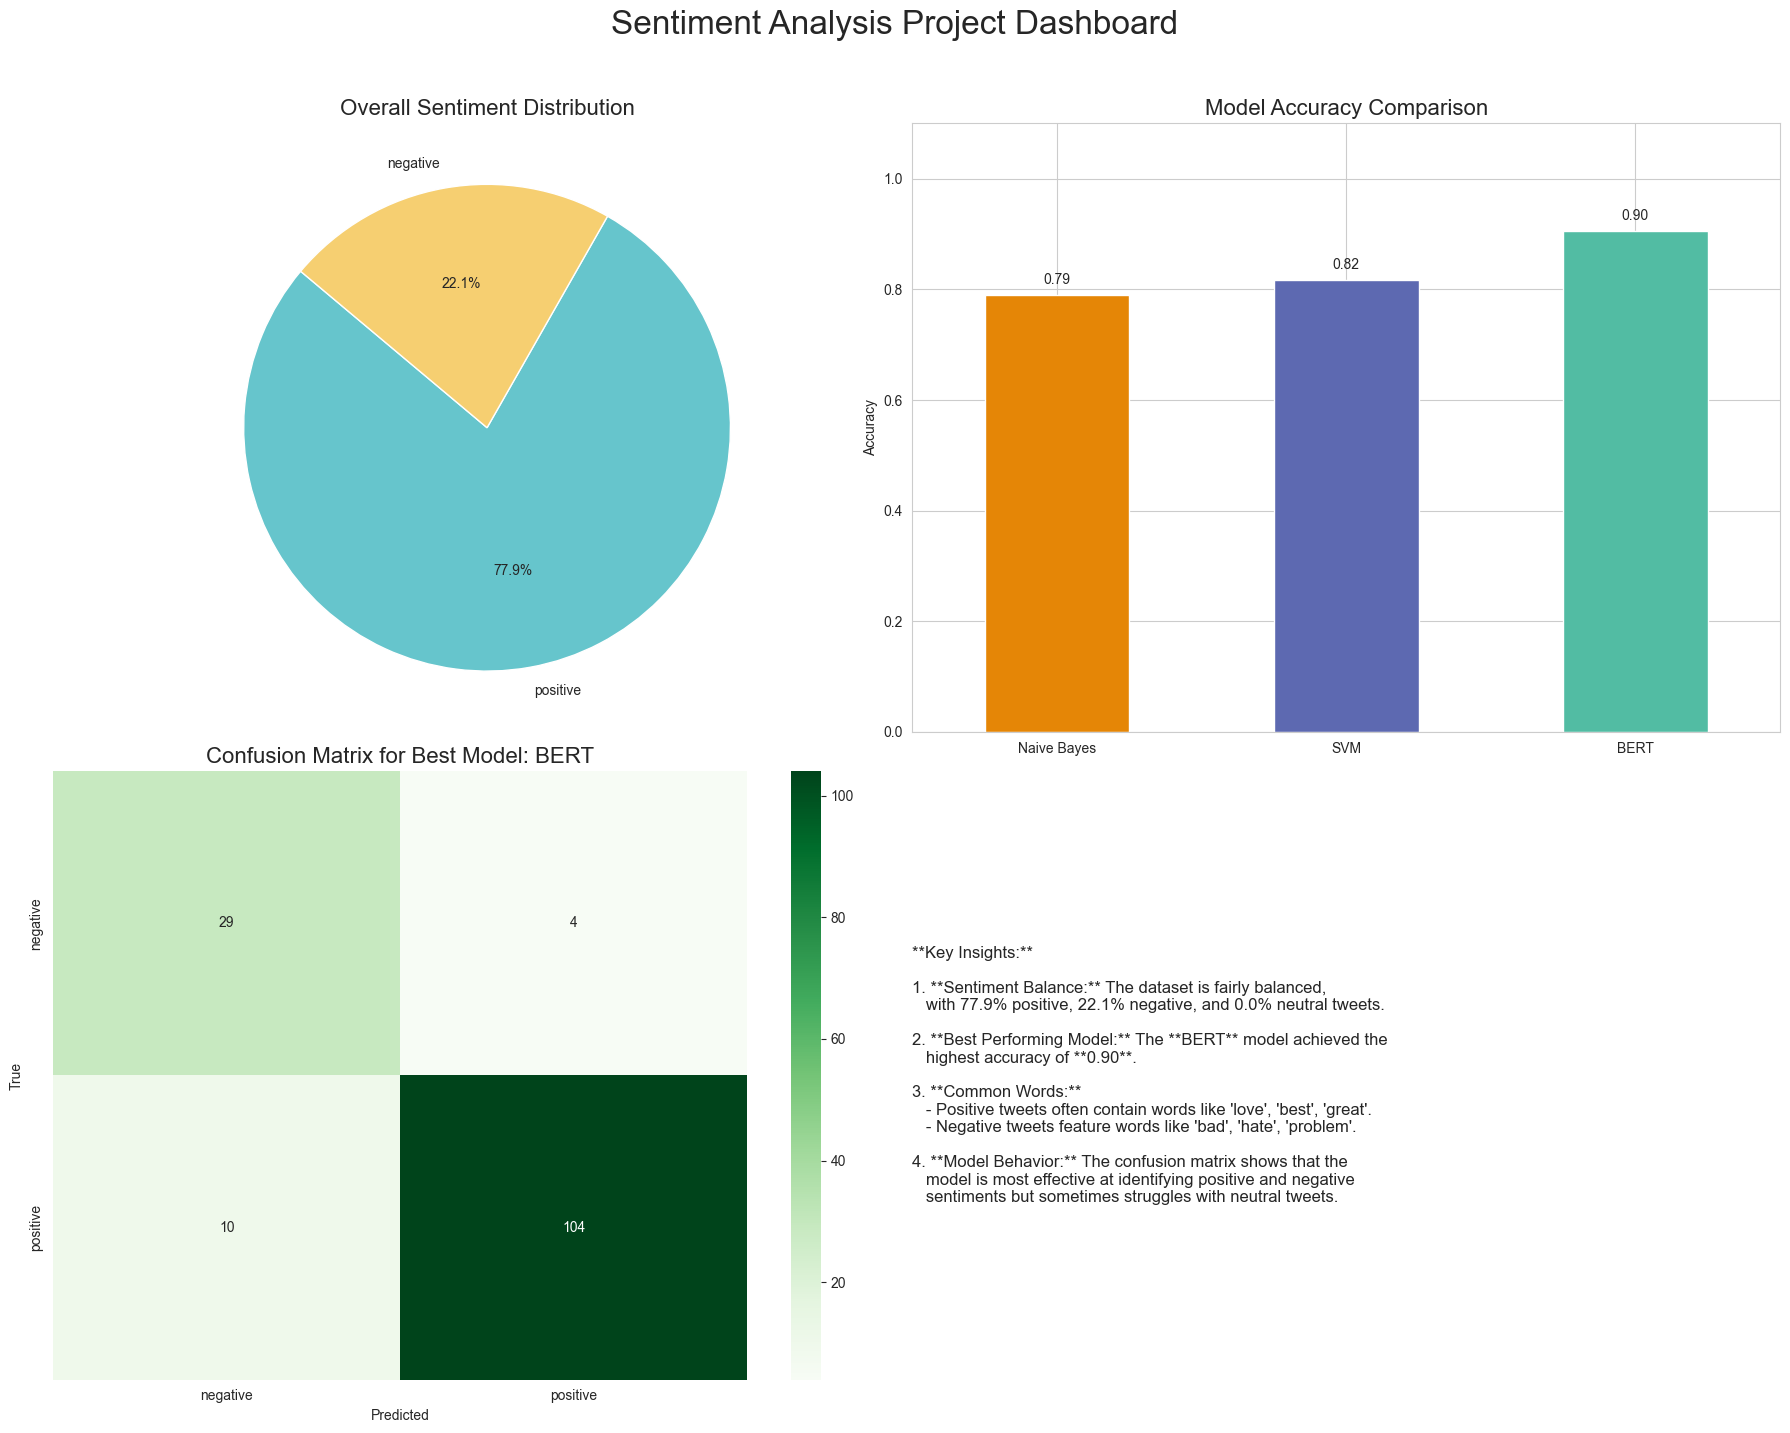

In [61]:
from itertools import cycle

# Convert Plotly rgb() strings to Matplotlib RGBA
def rgb_to_mpl(rgb_str):
    rgb = [int(x) for x in rgb_str.strip('rgb()').split(',')]
    return tuple([v/255 for v in rgb])

    
# Create a figure with subplots for the dashboard
fig, axes = plt.subplots(2, 2, figsize=(18, 14))
fig.suptitle('Sentiment Analysis Project Dashboard', fontsize=24, y=1.02)

# 1. Sentiment Distribution (Pie Chart)
sentiment_counts = df['sentiment'].value_counts()
pastel_colors = [rgb_to_mpl(c) for c in px.colors.qualitative.Pastel]

# Create a color cycle
color_cycle = cycle(pastel_colors)

# Assign a color to each slice
slice_colors = [next(color_cycle) for _ in range(len(sentiment_counts))]

# Plot pie chart with cycled colors
axes[0, 0].pie(
    sentiment_counts,
    labels=sentiment_counts.index,
    autopct='%1.1f%%',
    startangle=140,
    colors=slice_colors
)

axes[0, 0].set_title('Overall Sentiment Distribution', fontsize=16)

# 2. Model Performance Comparison (Bar Chart)
vivid_colors = [rgb_to_mpl(c) for c in px.colors.qualitative.Vivid]

color_cycle = cycle(vivid_colors)


results_df['Accuracy'].plot(
    kind='bar',
    ax=axes[0, 1],
    color=[next(color_cycle) for _ in range(len(results_df))]
)
axes[0, 1].set_title('Model Accuracy Comparison', fontsize=16)
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].tick_params(axis='x', rotation=0)
axes[0, 1].set_ylim(0, 1.1)
for i, v in enumerate(results_df['Accuracy']):
    axes[0, 1].text(i, v + 0.02, f'{v:.2f}', ha='center')

# 3. Confusion Matrix of the Best Model (SVM)
best_model_name = results_df['Accuracy'].idxmax()
y_pred_best = models[best_model_name]
cm = confusion_matrix(y_test, y_pred_best, labels=class_labels)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=class_labels, yticklabels=class_labels, ax=axes[1, 0])
axes[1, 0].set_title(f'Confusion Matrix for Best Model: {best_model_name}', fontsize=16)
axes[1, 0].set_xlabel('Predicted')
axes[1, 0].set_ylabel('True')

# 4. Key Insights (Text)
axes[1, 1].axis('off') # Hide the axes for the text block


# Calculate percentages
pos_pct = sentiment_counts.get('positive', 0) / len(df) * 100
neg_pct = sentiment_counts.get('negative', 0) / len(df) * 100
neu_pct = sentiment_counts.get('neutral', 0) / len(df) * 100
best_acc = results_df['Accuracy'].max()
best_model = best_model_name

insights = f"""
**Key Insights:**

1. **Sentiment Balance:** The dataset is fairly balanced,
   with {pos_pct:.1f}% positive, {neg_pct:.1f}% negative, and {neu_pct:.1f}% neutral tweets.

2. **Best Performing Model:** The **{best_model}** model achieved the
   highest accuracy of **{best_acc:.2f}**.

3. **Common Words:**
   - Positive tweets often contain words like 'love', 'best', 'great'.
   - Negative tweets feature words like 'bad', 'hate', 'problem'.

4. **Model Behavior:** The confusion matrix shows that the
   model is most effective at identifying positive and negative
   sentiments but sometimes struggles with neutral tweets.
"""


axes[1, 1].text(0, 0.5, insights, va='center', fontsize=12, wrap=True)

# Adjust layout and save the dashboard
plt.tight_layout()
plt.savefig('plots/final_dashboard.png')
plt.show()